# Learning from networks project: Evaluation of different Node Embedding algorithms
Members:<br>
- D'Emilio Filippo, id : 2120931
- Volpato Pietro, id : 2120825

## Embedding evaluation notebook

In [26]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import gzip
import re
import os
import random
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

# configuration
Here you can properly configure the names of the graphs and the names of the embedding strategies.<br>
Set emb_dim = 128 to load 128-dimensional embeddings, set emb_dim = 256 to load 256-dimensional embeddings.

In [2]:
graph_keys = ["facebook","citation","biological","proteins", "spam"]
embedding_keys = ["LINE", "node2vec", "AW"]
emb_dim = 128  # you can chose between 128 and 256 dimensional embeddings

# Loading the embeddings
Now we load the embeddings, which should be stored as a file in the /embeddings folder as a .npy file.<br>
*NOTE*: the file names must respect the format: "embeddings_{graph_key}_{embedding_key}.npy".<br>
Embeddings are stored in a dictionary of dictionaries.<br>
The first index refer to the graph (e.g. embeddings["facebook"] contains the embeddings of the facebook graph for every embedding technique).<br>
The second index refer to the embedding technique (e.g. embeddings["facebook"]["LINE"] cointans the embedding of facebook graph computed using LINE)

In [108]:
def load(name):
    """
    Loads a NumPy array from a file. If the file is not found, 
    displays a warning and returns None.

    name (str): The name of the file (without extension) to load from the 'embeddings' directory.
    
    return: np.ndarray or None: The loaded NumPy array, or None if the file is not found.
    """
    file_name = f"../result/{name}.npy"
    if not os.path.exists(file_name):
        print(f"Warning: File '{file_name}' not found.")
        return None

    emb = np.load(file_name)
    return emb

embeddings = {}
for k in graph_keys:
    embeddings[k] = {}

for graph_key in graph_keys:
    for emb_key in embedding_keys:
        s = f"embeddings_{graph_key}_{emb_key}_{emb_dim}"
        embeddings[graph_key][emb_key] = load(s)

# Loading the graphs
Selected graphs:
- Facebook_combined    https://snap.stanford.edu/data/ego-Facebook.html          
- cit-Helpth           https://networkrepository.com/cit-HepTh.php             
- bio-CE-CX            https://networkrepository.com/bio-CE-CX.php             
- proteins-full        https://networkrepository.com/PROTEINS-full.php ---- the graph has node labels
- spam                 https://networkrepository.com/web-spam-detection.php  ---- the graph has node labels

To run this notebook, adjust the paths to match where the files are saved in your PC.<br>
To keep paths as they are, download the repository.<br>
Graphs are stored as a dictionary: the key is the graph name, the value is the corresponding netowrkx graph.<br>

When it is created a networkX graph from a text file the node are renamed as integers form 0 to |V|-1, so that we can store the embeddings
on a matrix, and each row index corresponds to the embedding vector of the corrisponding node.

In [4]:
facebook_path = '../data/facebook/facebook_combined.txt.gz'
citation_path = '../data/citation/cit-HepTh.edges'
biological_path = '../data/biological/bio-CE-CX.edges'
proteins_path = "../data/proteins/PROTEINS-full.edges"
spam_path = "../data/spam/web-spam-detection.edges"

proteins_labels_path = "../data/proteins/PROTEINS-full.node_labels"
spam_labels_path = "../data/spam/web-spam-detection.node_labels"

In [5]:
def load_graph_edges(path):
    """
    For files with extension .edges
    nodes are renamed as integers, starting from 0
    """
    G = nx.Graph()
    with open(path, 'rt') as f:
        for line in f:
            if line.startswith('%'):  # Skip comment lines
                continue
            # Split the line based on spaces or commas
            data = re.split(r'[,\s]+', line.strip())
            if len(data) < 2:  # Skip lines that don't have at least two columns
                continue
            # Extract the first two columns (nodes)
            node1, node2 = int(data[0]), int(data[1])
            G.add_edge(node1, node2)
        
    return relabel_get_mapping(G)

def load_graph_with_gz(path):
    """
    For files with extension .txt.gz
    nodes are renamed as integers, starting from 0
    """
    G = nx.Graph()
    with gzip.open(path, 'rt') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
            
    return relabel_get_mapping(G)

def print_graphs_info(graphs):
    for k in graph_keys:
        G = graphs[k]
        print(f"{k}: |V|={len(G.nodes)}, |E|={len(G.edges)}")

def relabel_get_mapping(G):
    """
    Given a graph G, this function returns a graph where the nodes are relabeled as integers, form 0 to |V|-1.
    It is also returned the mapping from original name to relabeled name.
    """
    inverse_mapping = {i : node for i,node in enumerate(G.nodes)} # mappoing new_name : original_name
    direct_mapping = {node : i for i,node in enumerate(G.nodes)} # mapping original_name : new_name
    G = nx.relabel_nodes(G, direct_mapping)
    return G, direct_mapping

In [7]:
graphs = {}  # dictionary containg the graphs
mappings = {} # dictionary to contain the mappings. Original name : relabeled name
for k in graph_keys:
    mappings[k] = {}
    
# facebook graph is the only one .tar.gz        
graphs[graph_keys[0]], mappings[graph_keys[0]] = load_graph_with_gz(facebook_path)  # relabeling nodes to integer
graphs[graph_keys[1]], mappings[graph_keys[1]] = load_graph_edges(citation_path)
graphs[graph_keys[2]], mappings[graph_keys[2]] = load_graph_edges(biological_path)
graphs[graph_keys[3]], mappings[graph_keys[3]] = load_graph_edges(proteins_path)  # node labeled
graphs[graph_keys[4]], mappings[graph_keys[4]] = load_graph_edges(spam_path)  # node labeled

print_graphs_info(graphs)

facebook: |V|=4039, |E|=88234
citation: |V|=22908, |E|=2444798
biological: |V|=15229, |E|=245952
proteins: |V|=43471, |E|=81049
spam: |V|=9072, |E|=473854


## Extract the labels
The graph "proteins" has node labels. <br>
In the text file containing the labels each line has only one number (class label), and such element refers implicitly to the line number node, according to the original node names definition.<br>
Since when we load a graph we rename node as integers starting from 0, the mapping is applied to match each label with the correct node according
to the modified node names.<br>

In [9]:
def load_node_labels(file_path, graph_key):
    """
    Reads a file containing node labels and returns a dictionary mapping nodes to labels.
    The labels are assumed to be listed in sequential order: first label is relative to first node (according to original name), and so on...

    Parameters: file_path (str): Path to the node label file.
                graph_key : key of the graph, needed for the mappings between original and renamed nodes.
    

    Returns:
        node_labels (dict): A dictionary where keys are oroginal node names, values are their corresponding labels.
    """
    node_labels = {}
    with open(file_path, 'r') as file:
        i = 1 # keep track of incedes of original names because bad CL fata format
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if not line:  # Skip empty lines
                continue

            # i is the node original name, but labels skip nodes that are isolated
            map = mappings[graph_key]
            while i not in map.keys():  # skip isolated nodes
                i += 1
            
            real_name = map[i]
            label = int(line)  # Parse the labels
            node_labels[real_name] = label  # Map the line number (node ID) to the label
            i += 1

    return node_labels

labels = {}
labels["proteins"] = load_node_labels(proteins_labels_path, "proteins")
labels["spam"] = load_node_labels(spam_labels_path, "spam")

## 2D visualization of the embeddings

In [92]:
def visualize_embeddings(embeddings, labels=None, method="tsne", random_state=69):
    """
    Visualize embeddings in 2D space using t-SNE or PCA.
    
    Parameters:
        embeddings (np.ndarray): Embedding matrix of shape (n_nodes, dimensions).
        labels (list or np.ndarray): Optional, class labels for nodes. Used for coloring.
        method (str): Dimensionality reduction method ("tsne" or "pca").
        random_state (int): Random state for reproducibility.
        
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=random_state, init='random', perplexity=30)
        reduced_embeddings = reducer.fit_transform(embeddings)
    elif method == "pca":
        reducer = PCA(n_components=2, random_state=random_state)
        reduced_embeddings = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    plt.figure(figsize=(10, 7))
    if labels is not None:
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
        plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right", fontsize="small", markerscale=2)
    else:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10, alpha=0.8)
    
    plt.title(f"2D Visualization of Embeddings using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

## Choose the embeddings you want to visualize

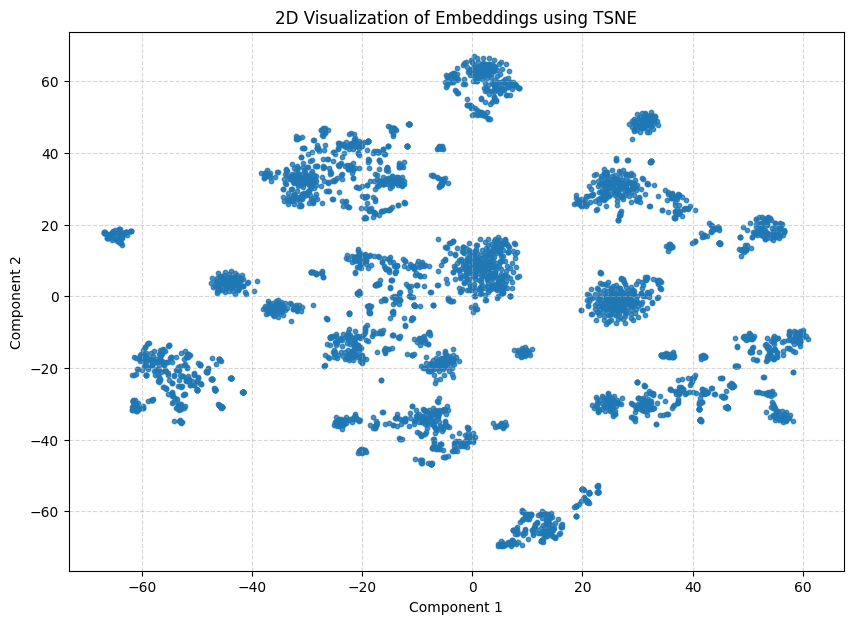

In [95]:
graph_key = "facebook"
embedding_key = "node2vec"
lab = None
if graph_key == "proteins": 
    # sort the labels in a list to visualize node classes colors
    lab = []
    for i in range(len(labels["proteins"])):
        lab.append(labels["proteins"][i])
        
visualize_embeddings(embeddings[graph_key][embedding_key], lab, method = 'tsne')

# Reconstruction error
The reconstruction error measures the ability of reconstructing the original graph using the node embedding vectors.<br>
Reconstruct the connections between nodes given the embeddings is not trivial, since different embedding techniques may produce the embedding vectors in very different ways, hence the best way to reconstruct the graph vary with the embedding strategy considered.<br>
Doing an exact computation of the reconstruction error implies to scan all possible pair of nodes, which is computationally infeasible for large graphs (10^5 nodes ----> 10^10 computation of similarities between pair of 128-dimensional vectors).<br>
To solve the computational complexity problem, we developed a simple approximation algorithm. <br>
First of all, we need to define a similarity function, that given the embeddings of two nodes, returns the similarity of those w.r.t. a define measure (e.g. cosine similarity, Euclidean distance). Note that a similarity measures might be optimal for an embedding strategy, and meaningless for another embedding strategy.<br>
The approximate_reconstruction_error() is a very simple algorithm based on sampling, and can be summaryzed in two steps:
1) Draw positive and negative samples to define a threshold, which will be the criterion to "guess" if, given pair of embedding vectors, there is an edge in the graph.
2) Draw new positive and negative samples, and use the similarity function and apply the threshold to such value to make the predictions. Then the reconstruction error is defined as the number of errors divided by the number of samples. Note that an error can be a FP: guess a non-existing edge, or a FN: missed to guess an existing edge.

INPUT:
- G=(V,E) undirected graph
- embeddings: matrix of embeddings, embeddings[i] is the embedding vector of node i
- sample_fraction: the fraction of the true edges considered
- sim_function: a function returning the similarity of two vectors. Assumption: higher (with sign) value represents higher similarity.

OUTPUT: approximated RE of G with given embeddings
<pre>
approximate_reconstruction_error(G, embeddings, sample_fraction, sim_function)<br>
{draw samples to define the similarity threshold}
positive_edges <---- draw uniformly at random sample_fraction*|E| edges
negative_edges <---- draw uniformly at random sample_fraction*|E| pair of nodes for which does not exist an edge in the graph
sim_pos <---- average similarity of all pair of nodes in positive_edges
sim_neg <---- average similarity of all pair of nodes in negative_edges
threshold <---- (sim_pos+sim_neg)/2
{draw samples to try reconstruct the graph}
positive_edges <---- draw uniformly at random sample_fraction*|E| edges
negative_edges <---- draw uniformly at random sample_fraction*|E| pair of nodes for which does not exist an edge in the graph
samples <---- [positive_edges,negative_edges]
errors <---- 0
for each (u,v) in samples:
    prediction <--- True if sim_function(embeddings[u],embeddings[v])>= threshold, False otherwise
    compare the prediction with the actual presence of edge (u,v) in the graph, and update error counter
return errors/|samples|
</pre>

The reconstruction error is in the interval [0,1]. RE = 1 means that (approximately) we are able to perfectly reconstruct the original graph gigen the embedding vectors. <br>
NOTES:
- We are free to choose the similarity function that is more meaningful w.r.t. the embedding strategy, for example the cosine similarity works perfectly with LINE embeddings, but very poorly for node2vec or Attention Walk. This is because of how the embeddings are generated: LINE embeddings are optimized to explicitly preserve proximity between nodes, making cosine similarity a natural measure of similarity. For other methods like Node2Vec and Attention Walk, the embeddings might encode other structural properties that cosine similarity fails to capture.
- The computation of the reconstruction error might seem similar to a link prediction task, but there is a big key difference: in link prediction we are training a model providing examples, constituted by the features and the ground truth (1 = edge, 0 = no edge). During the computation of the RE instead we are only using the embeddings trying to guess the presence of edges, without ever having any information of the ground truth.

In [103]:
def similarity_function(x,y, sim_function = "euclidean distance"):
    if sim_function == "cosine similarity":
        return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0, 0]
    if sim_function == "euclidean distance":
        return -np.linalg.norm(x - y)  # since the returned value is interpreted as a similarity, - sign
    
def approximate_reconstruction_error(G, embeddings, sample_fraction=0.1, sim_function = "euclidean distance"):
    """
    Computes an approximate reconstruction error for a graph embedding.
    
    Parameters:
        G (nx.Graph): Input graph.
        embeddings (np.ndarray): Embedding matrix (n_nodes x dimensions).
        sample_fraction (float): Fraction of edges to sample for evaluation.
        sim_function: defines what metric is used to establish the similarity between two embedding vectors
    
    Returns:
        dict: Reconstruction error and additional statistics (e.g., FP, FN).
    """
    if sim_function not in ["cosine similarity", "euclidean distance"]:
        print("Possible values of sim_function: cosine similarity, euclidean distance")
        return None
        
    nodes = list(G.nodes())
    n_samples = int(sample_fraction * G.number_of_edges())

    # pick the samples to compute average cosine similarity of positive and negative edges
    positive_edges = random.sample(list(G.edges()), n_samples)
    negative_edges = []
    while len(negative_edges) < len(positive_edges):
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.append((u, v))
            
    # average cos sim for existing edges
    sim_pos = np.mean([similarity_function(embeddings[u], embeddings[v], sim_function) for u,v in positive_edges])
    sim_neg = np.mean([similarity_function(embeddings[u], embeddings[v], sim_function) for u,v in negative_edges])

    # define threshold for reconstruction of the graph
    threshold = (sim_pos+sim_neg)/2

    # pick new fresh samples to approximate the reconstructon ability of the graph
    positive_edges = random.sample(list(G.edges()), n_samples)
    negative_edges = []
    while len(negative_edges) < len(positive_edges):
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.append((u, v))

    errors = 0
    fp = 0
    fn = 0
    samples = positive_edges + negative_edges  # concatenate the samples
    for u,v in samples:
        sim = similarity_function(embeddings[u], embeddings[v], sim_function)
        prediction = True if sim >= threshold else False
        if prediction == True and not G.has_edge(u, v):  # false positive
            errors+=1
            fp+=1
        if prediction == False and  G.has_edge(u, v):  # false positive
            errors+=1
            fn+=1
    re = errors/len(samples)
    fp_rate = fp/len(samples)
    fn_rate = fn/len(samples)
    return {
        "re": re,
        "fp_rate": fp_rate,
        "fn_rate": fn_rate,
        "sim_pos": sim_pos,
        "sim_neg": sim_neg
    }
    
def print_reconstruction_error(dict, graph_name , embedding_technique, sim_function, show_all):
    re = dict["re"]
    fp_rate = dict["fp_rate"]
    fn_rate = dict["fn_rate"]
    sim_pos = dict["sim_pos"]
    sim_neg = dict["sim_neg"]
    if show_all:
        s = f"RE ({sim_function}) of {graph_name} using {embedding_technique} = {re:.4f}. FP rate = {fp_rate:.4f}. FN rate = {fn_rate:.4f}. "
        s += f"avg_pos = {sim_pos:.4f}, avg_neg = {sim_neg:.4f}"
        print(s)
    else:
        print(f"RE of {graph_name} using {embedding_technique} = {re:.4f}")
        
def compute_all_reconstruction_errors(graph_keys, embedding_keys, sample_fraction=0.1, sim_function = 'euclidean distance', show_all = True):
    for graph_key in graph_keys:
        for emb_key in embedding_keys:
            G = graphs[graph_key]
            E = embeddings[graph_key][emb_key]
            if  E is not None and E.size != 0:
                dict = approximate_reconstruction_error(G, E, sample_fraction = sample_fraction, sim_function = sim_function)
                print_reconstruction_error(dict, graph_key, emb_key, sim_function, show_all = show_all)

## Compute the RE
Here you can compute the reconstruction error.<br>
- Set graph_keys_RE with the keys of the graphs you are interested. graph_keys_RE = graph_keys for all graphs.<br>
- set embedding_keys_RE with the keys of the embedding strategies you are interested. graph_keys_RE = embedding_keys for all embedding strategies.<br>

In [109]:
graph_keys_RE = ["facebook", "biological", "proteins", "spam"]
embedding_keys_RE = ["node2vec"]

sample_fraction = 0.05
show_all = True
sim_function = "euclidean distance"  # cosine similarity, euclidean distance

compute_all_reconstruction_errors(graph_keys_RE, embedding_keys_RE, sample_fraction = sample_fraction, sim_function = sim_function, show_all = show_all)

RE (euclidean distance) of facebook using node2vec = 0.4960. FP rate = 0.1801. FN rate = 0.3159. avg_pos = -4.3801, avg_neg = -4.3910
RE (euclidean distance) of biological using node2vec = 0.5444. FP rate = 0.2777. FN rate = 0.2668. avg_pos = -4.6331, avg_neg = -4.5180
RE (euclidean distance) of proteins using node2vec = 0.5042. FP rate = 0.2458. FN rate = 0.2584. avg_pos = -5.8492, avg_neg = -5.8486
RE (euclidean distance) of spam using node2vec = 0.4024. FP rate = 0.1851. FN rate = 0.2173. avg_pos = -4.1044, avg_neg = -4.4026


# NODE CLASSIFICATION

## Analysis of the datasets
It is always a good idea to have a look at the datasets we are dealing with.<br>
- features are the embeddings of the nodes, which is an D-dimensional vector, where D is the dimension of the specific embeddings
we are using to training.
- the labels represent the classes of the nodes. We can analyze the labels set to see how many different classes there are and understand how balanced the dataset is.

In [14]:
def analyze_labels(labels):
    labels_count = {}
    for label in labels.values():
        if not label in labels_count.keys():
            labels_count[label] = 0
        labels_count[label] += 1
    print(f"Number of samples: {len(labels)}")
    print(f"Number of classes: {len(labels_count)}")
    for label in labels_count.keys():
        print(f"Samples of class {label}: {labels_count[label]}")

print("INFO DATASET PROTEINS GRAPH")
analyze_labels(labels["proteins"])

print("INFO DATASET SPAM GRAPH")
analyze_labels(labels["spam"])

INFO DATASET PROTEINS GRAPH
Number of samples: 43471
Number of classes: 3
Samples of class 0: 21151
Samples of class 1: 20931
Samples of class 2: 1389
INFO DATASET SPAM GRAPH
Number of samples: 9072
Number of classes: 3
Samples of class 2: 6365
Samples of class 1: 594
Samples of class 3: 2113


## Train and evaluate the model
A support vector machine is trained from the dataset provided in input.<br>
Class weights are used to handle the case of an imbalance dataset (some classes have considerably less examples than others).<br>
The model is trained on 80% of the dataset (training set), while 20% of the dataset (test set) is left to make predictions and evaluate the performances of the classifier.

In [24]:
def train_SVM(embeddings, labels):
    """
    Train and evaluate an SVM classifier for multi-class node classification.

    Parameters:
        embeddings (np.ndarray): Numpy array where each row is a node's embedding.
        labels (dict): Dictionary mapping node indices to their labels.

    Returns:
        dict: A dictionary with accuracy, F1 score, and a detailed classification report.
    """
    # Ensure X (features) and y (labels) are aligned
    X = np.array(embeddings)  # Node embeddings
    scaler = StandardScaler()
    X = scaler.fit_transform(X)  # normalization
    y = np.array([labels[i] for i in range(len(labels))])  # Ensure correct ordering of labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

    smote = SMOTE(random_state=42, sampling_strategy = 'auto') # (Synthetic Minority Oversampling Technique) 
    X_train, y_train = smote.fit_resample(X_train, y_train)  #resampling to handle imbalance dataset

    #clf = SVC(kernel='rbf', class_weight = 'balanced', decision_function_shape='ovo')  # 'ovo' = one-vs-one for multi-class
    clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, sampling_strategy = 'all', bootstrap = False, replacement = True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred)

    # Print results
    print("SVM Classifier Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {f1:.4f}")
    print("Classification Report:\n", report)

    # Return results as a dictionary
    return {"accuracy": accuracy, "macro_f1": f1, "report": report}

## Choose the graph and the embedding strategy to train the model

In [27]:
embedding_key = "LINE"
graph_key = "spam"
x = train_SVM(embeddings[graph_key][embedding_key], labels[graph_key])

SVM Classifier Results:
Accuracy: 0.6094
Macro F1-Score: 0.3905
Classification Report:
               precision    recall  f1-score   support

           1       0.30      0.24      0.27       134
           2       0.68      0.81      0.74      1258
           3       0.24      0.12      0.16       423

    accuracy                           0.61      1815
   macro avg       0.41      0.39      0.39      1815
weighted avg       0.55      0.61      0.57      1815



# LINK PREDICTION
The link prediction task consists on training a model, logistic regression in this case, that given as input the features of a pair of nodes predicts whether the edge between them exists in the graph or not.<br>

## PRODUCING THE DATASET
We decided to produce a perfectly balanced dataset in this way: all the positive examples are all the pair of nodes (actually the features we decided to use to represent them) for which exists an edge in the graph.<br>
The negative examples instead are created by chosing at random a pair of nodes, and if there is no edge between them such pair is a negative example. We repeat this procedure until the number of negative examples matches the number of positive examples<br>

We defined 3 possible choices for the features representing pair of nodes:
- The concatenation of the embeddings of the two nodes
- The concatenation of the embeddings + the cosine similarity between those (a scalar)
- Just the scalar cosine similarity between the two embeddings

In [28]:
def create_link_prediction_dataset(G, embeddings, add_cosine_sim = True):
    """
    Creates a dataset for link prediction. if add_cosine_sim = False, the features are the concatenation
    between the embedding of pair on nodes, if add_cosine_sim = True it is concatenated in addition the
    cosine similarity between the two embeddings (1 additional feature)

    Parameters:
        G (nx.Graph): The input graph.
        embeddings (np.ndarray): Node embeddings as a numpy array (indexed by node ID).
        add_cosine_sim: if True the cosine similarity is concatenated to the embeddings to produce the features

    Returns:
        X (np.ndarray): Feature pairs with cosine similarity as an additional feature.
        y (np.ndarray): Labels (1 for existing edges, 0 for non-existing edges).
    """
    positive_edges = list(G.edges())
    num_positive = len(positive_edges)

    # Generate negative edges
    nodes = list(G.nodes())
    negative_edges = set()
    while len(negative_edges) < num_positive:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.add((u, v))

    # Combine positive and negative edges
    all_edges = positive_edges + list(negative_edges)
    labels = [1] * len(positive_edges) + [0] * len(negative_edges)

    # Create features from embeddings
    X = []
    for u, v in all_edges:
        # Compute cosine similarity
        u_emb = embeddings[u].reshape(1, -1)
        v_emb = embeddings[v].reshape(1, -1)
        if add_cosine_sim:         # Concatenate embeddings and cosine similarity
            cosine_sim = cosine_similarity(u_emb, v_emb)[0, 0]
            feature = np.concatenate([embeddings[u], embeddings[v], [cosine_sim]])
        else:
            feature = np.concatenate([embeddings[u], embeddings[v]])
        X.append(feature)

    X = np.array(X)
    y = np.array(labels)

    return X, y

In [29]:
def create_link_prediction_dataset_only_cosine_similarity(G, embeddings):
    """
    Creates a dataset for link prediction, where each sample has a single feature (scalar), which is the cosine similarity
    between the two nodes adjacent to the edge.
    """
    positive_edges = list(G.edges())
    num_positive = len(positive_edges)

    # Generate negative edges
    nodes = list(G.nodes())
    negative_edges = set()
    while len(negative_edges) < num_positive:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.add((u, v))

    # Combine positive and negative edges
    all_edges = positive_edges + list(negative_edges)
    labels = [1] * len(positive_edges) + [0] * len(negative_edges)

    # Create features from embeddings
    cosine_similarities = []
    for u, v in all_edges:
        # Compute cosine similarity
        u_emb = embeddings[u].reshape(1, -1)
        v_emb = embeddings[v].reshape(1, -1)
        cosine_sim = cosine_similarity(u_emb, v_emb)[0, 0]
        cosine_similarities.append(cosine_sim)

    X = np.array(cosine_similarities).reshape(-1, 1)
    y = np.array(labels)

    return X, y

## TRAIN LOGISTIC REGRESSION CLASSIFIER

In [30]:
def LR_link_prediction(X,y):
    """
    Train a logistic regression classifier for link prediction
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)  # normalization
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

    # Train logistic regression model
    clf = LogisticRegression(max_iter = 1000)
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [32]:
embedding_key = "LINE"
graph_key = "spam"
X,y = create_link_prediction_dataset_only_cosine_similarity(graphs[graph_key], embeddings[graph_key][embedding_key])
LR_link_prediction(X,y)

Accuracy: 0.9004864357240084
ROC AUC Score: 0.9540717218359781
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     94573
           1       0.90      0.90      0.90     94969

    accuracy                           0.90    189542
   macro avg       0.90      0.90      0.90    189542
weighted avg       0.90      0.90      0.90    189542



## Neighborhood preservation
To compute the top-k nearest neighbors (k-NN) we use FAISS (Facebook AI Similarity Search), which is an approximation algorithm to compute the k-NN for each node in the graph. Since we are evaluating neighborhood preservation of the embeddings, we excluded from the top-k list the node itself (FAISS include by default the node itself as its nearest neighbor).<br>
The neighborhood preservation score is defined as follow:<br>

INPUT:
- G = (V,E): undirected graph
- embeddings: numpy array, where embeddings[i] is the embedding vector of node i in G
- k: for each node are extracted the top-k neighbors in the embedding space
- order: can be either 1 or 2. The neighborhood of u G is defined as the set of nodes reachable from u with a path of lenght "order" (1 or 2)

OUTPUT: neighborhood preservation score

<pre>
neighborhood_preservation_score(G, embeddings, k, order)
    
extract top-k neighbors in embedding space using FAISS for each node in V
for each node v in V:
    let i be the order of neighborhood considered
    let Nv be the set of i-th order neighborhood of v
    let k-NNv be the set of top-k nearest neighbors of v in the embedding space (euclidean distance)
    overlap <---- |Nv INTERSECTION k-NNv|
    normalization <---- MIN{|Nv|, k}   (k = |k-NNv|)
    score(v) <---- overlap / normalization
n_p_score <---- (sum of score(v) for all v in V) / |V|
return n_p_score
</pre>

The returned score is always in the interval [0,1]. The goal of the neighborhood preservation score is to have a an ojbective quantity
that tells if the neighbors of the nodes in the embeddings space match with the actual neighbors of the nodes in the graph. 
<br>

Consider a node v.
- if |Nv| <= k ( MIN = |Nv|), then the score represents how many nodes in Nv are also in k-NNv. (1 = all |Nv| nodes, 0 = none)
- if |Nv| > k ( MIN = k), then the score represents how many nodes in k-NNv are also in Nv. (1 = all k nodes, 0 = none)


In [75]:
import faiss

def get_k_nearest_neighbors(embeddings, k = 5):
    # Create FAISS index for L2 similarity
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    
    # Add embeddings to the index
    index.add(embeddings)
    
    # Query for top-k nearest neighbors
    distances, indices = index.search(embeddings, k + 1)  # Query for k+1 neighbors
    top_k_neighbors = [ind[1:] for ind in indices]  # Exclude self (first neighbor)
    return top_k_neighbors

def neighborhood_preservation_score(G, embeddings, k = 5, order = 1):
    if order not in [1,2]:
        print("Order must be either 1 (first order neighborhood) or 2 (second order neighborhood)")
    top_k_neighbors = get_k_nearest_neighbors(embeddings, k=k)
    scores = []
    for v in G.nodes():
        Nv = set(G.neighbors(v))
        if order == 2:
            for u in G.neighbors(v):
                Nv = Nv.union(set(G.neighbors(u)))
        k_NN = set(top_k_neighbors[v])
        overlap = len(Nv & k_NN)
        normalization = min(len(Nv), k)
        scores.append(overlap/normalization)
    return np.mean(scores)

In [90]:
g_keys = ["facebook"]
e_keys = ["node2vec"]
order = 2

for gk in g_keys:
    for ek in e_keys:       
        G = graphs[gk]
        E = embeddings[gk][ek]
        score = neighborhood_preservation_score(G, E, k = 5, order = order)
        print(f"Order {order} neighborhood preservation score of {gk} with {ek}: {score}")

Order 2 neighborhood preservation score of facebook with node2vec: 0.3947016588264422
